In [1]:
import torch
import torchtext
from torchtext.datasets import text_classification
import torch.nn as nn
import torch.nn.functional as F
import os
import time
import copy
import matplotlib.pyplot as plt

In [2]:
data_path = './data'
ngrams = 2

#train_dataset, test_dataset = text_classification.DATASETS['YelpReviewFull'](
#    root=data_path, ngrams=ngrams, vocab=None)

In [3]:
#torch.save(train_dataset, 'train_dataset.pt')
#torch.save(test_dataset, 'test_dataset.pt')

In [4]:
train_dataset = torch.load('train_dataset.pt')
test_dataset = torch.load('test_dataset.pt')

In [5]:
class textSentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embedding_dim, sparse=True)
        self.fc = nn.Linear(embedding_dim, num_classes)
        self.initWeights()
        
    def initWeights(self):
        initrange = 0.5
        # initialize weights with an uniform distribution
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        """
        Arguments:
            text: 1-D tensor representing a bag of text tensors
            offsets: a list of offsets to delimit the 1-D text tensor
                into the individual sequences.
        """
        return self.fc(self.embedding(text, offsets))

In [6]:
embedding_dim = 16
vocab_size = len(train_dataset.get_vocab())

classes = train_dataset.get_labels()
num_classes = len(classes)

print('Classes:', classes)

Classes: {0, 1, 2, 3, 4}


In [7]:
def generateBatch(batch):
    text = [bt[1] for bt in batch]
    
    offsets = torch.tensor([0] + [len(t) for t in text[:-1]])  # starts with 0 and discards the last element
    offsets = torch.cumsum(offsets, dim=0)
    
    labels = torch.tensor([bt[0] for bt in batch])
    
    text = torch.cat(text, dim=0)
    return text, offsets, labels

In [8]:
batch_size = 16

# split dataset
train_size = int(0.95 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# create training data loader
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, collate_fn=generateBatch)

# create validation data loader
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, collate_fn=generateBatch)

In [9]:
torch.cuda.empty_cache()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using gpu: ", use_cuda)

Using gpu:  True


In [10]:
learning_rate = 4

text_classification = textSentiment(vocab_size, embedding_dim, num_classes).to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(text_classification.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)


In [11]:
PATH_state_dict=('./text_class.pth')

In [12]:

def train(model, criterion, optimizer, scheduler, epochs=8):
    start_time = time.time()

    best_parameters = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    best_epoch = 0
    all_cost_train = []
    all_cost_val = []

    for epoch in range(epochs):
        epoch_start_time = time.time()
        
        print('Epoch: {}'.format(epoch+1))
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
                dataset_size = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
                dataset_size = val_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, offsets, labels in dataloader:
                inputs = inputs.to(device)
                offsets = offsets.to(device)
                labels = labels.to(device)
                

                optimizer.zero_grad() # reset gradients attribute to zero

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs, offsets)
                    #_, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() #* inputs.size(0)
                running_corrects += torch.sum(outputs.argmax(1) == labels).item()
                #running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects / dataset_size
            #epoch_acc = running_corrects.double() / dataset_size
            
            if phase == 'train':
                all_cost_train.append(epoch_loss)
            else:
                all_cost_val.append(epoch_loss)

            print('[{}] -> Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_parameters = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        epoch_time_elapsed = time.time() - epoch_start_time
        print('{:.0f}m {:.0f}s'.format(
            epoch_time_elapsed // 60, epoch_time_elapsed % 60))
        print('-' * 20)

    time_elapsed = time.time() - start_time
    print()
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    print('Best validation Acc: {:4f} , occured in epoch: {}'.format(
        best_val_acc, best_epoch+1))

    # load best model weights
    model.load_state_dict(best_parameters)
    # save model to file
    #torch.save(model.state_dict(), PATH_state_dict)
    
    plt.plot(all_cost_train,label='Train Loss',color='blue')
    plt.plot(all_cost_val,label='Val Loss',color='green')
    plt.title('Overall loss')
    plt.ylabel('Cost')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    return model

Epoch: 1
[train] -> Loss: 0.0662 Acc: 0.5414
[val] -> Loss: 0.0594 Acc: 0.5955
0m 39s
--------------------
Epoch: 2
[train] -> Loss: 0.0585 Acc: 0.5960
[val] -> Loss: 0.0588 Acc: 0.6032
0m 34s
--------------------
Epoch: 3
[train] -> Loss: 0.0552 Acc: 0.6199
[val] -> Loss: 0.0577 Acc: 0.6175
0m 34s
--------------------
Epoch: 4
[train] -> Loss: 0.0525 Acc: 0.6392
[val] -> Loss: 0.0588 Acc: 0.6107
0m 34s
--------------------
Epoch: 5
[train] -> Loss: 0.0502 Acc: 0.6553
[val] -> Loss: 0.0609 Acc: 0.5983
0m 35s
--------------------
Epoch: 6
[train] -> Loss: 0.0481 Acc: 0.6723
[val] -> Loss: 0.0590 Acc: 0.6184
0m 36s
--------------------
Epoch: 7
[train] -> Loss: 0.0460 Acc: 0.6875
[val] -> Loss: 0.0619 Acc: 0.6006
0m 35s
--------------------
Epoch: 8
[train] -> Loss: 0.0440 Acc: 0.7038
[val] -> Loss: 0.0606 Acc: 0.6130
0m 37s
--------------------

Training completed in 4m 44s
Best val Acc: 0.618369 , occured in epoch: 6


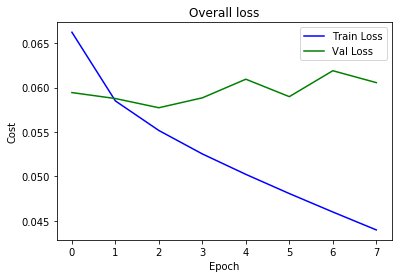

textSentiment(
  (embedding): EmbeddingBag(6854233, 16, mode=mean)
  (fc): Linear(in_features=16, out_features=5, bias=True)
)

In [13]:
train(text_classification, criterion, optimizer, scheduler, epochs=8)

In [14]:
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer


def predict(text, model, dictionary, ngrams):
    """
    The predict() function here is used to test the model on a sample text.
    The input text is numericalized with the vocab and then sent to
    the model for inference.
    Arguments:
        text: a sample text string
        model: the trained model
        dictionary: a vocab object for the information of string-to-index
        ngrams: the number of ngrams.
    """
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([dictionary[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()
    

In [15]:
stars_class = {0 : "★", 1 : "★★", 2 : "★★★", 3 : "★★★★", 4 : "★★★★★"}

dictionary = train_dataset.get_vocab()
model = text_classification.to("cpu")

In [26]:
import csv
with open('data/yelp_review_full_csv/test.csv') as csvfile:
    test_dataset_csv = csv.reader(csvfile)
    
    for i, row in enumerate(test_dataset_csv):

        print("{}\n{} ({})".format(
            row[1], stars_class[predict(row[1], model, dictionary, ngrams)], stars_class[int(row[0])]))
        print()
        if i ==20:
            break

I got 'new' tires from them and within two weeks got a flat. I took my car to a local mechanic to see if i could get the hole patched, but they said the reason I had a flat was because the previous patch had blown - WAIT, WHAT? I just got the tire and never needed to have it patched? This was supposed to be a new tire. \nI took the tire over to Flynn's and they told me that someone punctured my tire, then tried to patch it. So there are resentful tire slashers? I find that very unlikely. After arguing with the guy and telling him that his logic was far fetched he said he'd give me a new tire \"this time\". \nI will never go back to Flynn's b/c of the way this guy treated me and the simple fact that they gave me a used tire!
★ (★★)

Don't waste your time.  We had two different people come to our house to give us estimates for a deck (one of them the OWNER).  Both times, we never heard from them.  Not a call, not the estimate, nothing.
★ (★★)

All I can say is the worst! We were the only